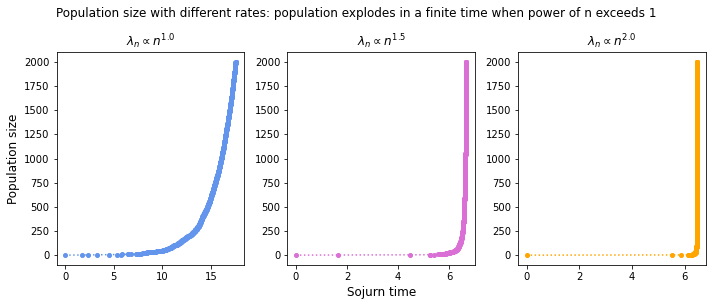

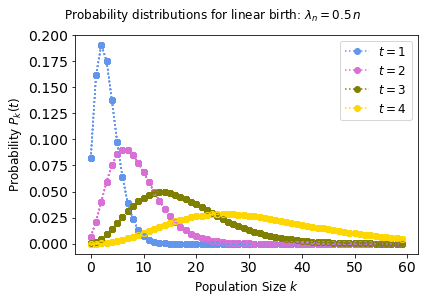

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import scipy.special
from matplotlib.lines import Line2D 
from cycler import cycler


def Pure_birth(b, num_steps, num_sim, p0, k): 
    
    soj_time = np.zeros((num_sim, num_steps))
    pop_size = np.zeros((num_sim, num_steps))
    pop_size[:,0] = p0

    for j in range(num_sim):
        for i in range(num_steps-1):
            U = np.random.uniform(0,1)
            h = - np.log(U)/(b*pop_size[j,i]**k)
            soj_time[j,i+1] = soj_time[j,i] + h
            pop_size[j,i+1] = pop_size[j,i] + 1 
            
    return [soj_time, pop_size]

 
def probdist(N, b):
    t = np.arange(1, N)
    k = np.arange(0, 60)
    p = np.zeros((len(t), len(k)))
    
    for i in range(len(t)):
        for j in range(len(k)):
            p[i][j] = scipy.special.binom(N+k[j]-1, k[j])*np.exp(-b*N*t[i])*(1-np.exp(-b*t[i]))**k[j]
        
    return [p, t, k]


def samplepath_plots(b, num_steps, num_sim, p0, r):
    
    fig, ax = plt.subplots(1,len(r),figsize=(10,4))
    col = ['cornflowerblue', 'orchid', 'orange']
    marker_style = dict(linestyle=':',marker='o', markersize=4) 
    
    for i, j in enumerate(r):
        [soj_time, pop_size] = Pure_birth(b, num_steps, num_sim, p0, j)
        ax[i].plot(soj_time[0,:], pop_size[0,:], color=col[i], **marker_style)
        ax[i].set_title('$\lambda_{n}\propto n^{%1.1f}$'%j)
    ax[0].set_ylabel('Population size',fontsize=12)
    ax[1].set_xlabel('Sojurn time',fontsize=12)
    plt.suptitle('Population size with different rates:'\
                 ' population explodes in a finite time when power of n exceeds 1', y=1.05)    
    plt.tight_layout()
    plt.show()
    
    
def dist_plots(N, b):
    
    fig, ax = plt.subplots()
    mycolors = ['cornflowerblue', 'orchid', 'olive', 'gold']
    colors = ax.set_prop_cycle(cycler('color', mycolors))
    marker_style = dict(color=colors, linestyle=':',marker='o', markersize=6) 
    
    [p, t, k] = probdist(N, b)
    for y, fill_style in enumerate(Line2D.fillStyles): 
        for r in range(len(t)):
            ax.plot(k, p[r][:], fillstyle=fill_style, **marker_style)
    ax.set_xlabel('Population Size $k$', fontsize=12) 
    ax.set_ylabel('Probability $P_k(t)$', fontsize=12)
    plt.legend(['$t=%s$' % str(i+1) for i in range(len(t))], fontsize=12, loc=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.suptitle('Probability distributions for linear birth: $\lambda_{n}=0.5\,n$', y=1.04)
    plt.show()    

    
b = 0.5
p0 = 1
r = [1,1.5,2]
num_steps = 2000
num_sim = 1 # one realization
N = 5

samplepath_plots(b, num_steps, num_sim, p0, r)
dist_plots(N, b)
 